# Flower Image Classification

### Prologue
This notebook focuses on classifying flower images using classical machine learning techniques. Four main models are built and evaluated: K-Nearest Neighbors (KNN), Logistic Regression, Support Vector Machine (SVM), and Naive Bayes. The images are converted into meaningful numerical features, and an analysis is conducted to understand the contribution of each feature to the classification performance.

### Dataset Overview
The dataset consists of grayscale images of five flower types: daisy, dandelion, rose, sunflower, and tulip. Each image is resized to 32×32 pixels, converted to grayscale, and represented by numerical features including pixel-level statistics and engineered descriptors. The dataset is balanced so that each class has the same number of samples.




In [1]:
# Core libraries 
import os
import time
import random
import numpy as np
import pandas as pd
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: preprocessing & selection 
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Scikit-learn: models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

# Scikit-learn: evaluation 
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    confusion_matrix as sk_confusion_matrix  # used if named explicitly in code
)


##  Data Loading & Preprocessing

### Load Image Data

In [2]:
# Constants
IMAGE_SIZE = (32, 32)
DATASET_PATH = "flowers"
CLASSES = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

# Load image data and extract features
def load_image_data():
    data = []
    labels = []

    for class_name in CLASSES:
        class_path = os.path.join(DATASET_PATH, class_name)
        for img_file in os.listdir(class_path):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                try:
                    img_path = os.path.join(class_path, img_file)
                    img = Image.open(img_path).convert('L')  # Convert to grayscale
                    img = img.resize(IMAGE_SIZE)
                    img_array = np.array(img).flatten()

                    # Feature Engineering: add mean and std dev of pixel values
                    avg_pixel = np.mean(img_array)
                    std_pixel = np.std(img_array)
                    img_array = np.append(img_array, [avg_pixel, std_pixel])

                    data.append(img_array)
                    labels.append(class_name)
                except Exception as e:
                    print(f"Error loading {img_file}: {e}")

    # --- Balance classes to have the same number of samples per class ---
    from collections import defaultdict

    class_to_images = defaultdict(list)
    for img_array, label in zip(data, labels):
        class_to_images[label].append(img_array)

    # Find the minimum number of samples across all classes
    min_samples = min(len(imgs) for imgs in class_to_images.values())

    # Downsample each class to match the minimum number
    balanced_data = []
    balanced_labels = []

    for label, imgs in class_to_images.items():
        np.random.shuffle(imgs)
        selected_imgs = imgs[:min_samples]
        balanced_data.extend(selected_imgs)
        balanced_labels.extend([label] * min_samples)

    # Update data with balanced version
    data = balanced_data
    labels = balanced_labels

    # Create a DataFrame from the data
    df = pd.DataFrame(data)
    df['label'] = labels

    print(df['label'].value_counts())    
    
    return df

# Load and preprocess the dataset
df = load_image_data()

# Extract feature matrix (X) and target vector (y)
X = df.drop("label", axis=1).values
y_raw = df["label"].values

# Encode labels as integers
le = LabelEncoder()
y = le.fit_transform(y_raw)

label
daisy        733
dandelion    733
rose         733
sunflower    733
tulip        733
Name: count, dtype: int64


###  Normalize and Standardize

In [3]:

# Normalize pixel values
X = X / 255.0

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


##  Exploratory Data Analysis (EDA)
Let's start by visualizing how the dataset is distributed across classes, and what the image-level statistics (mean, std) look like.

### Class distribution

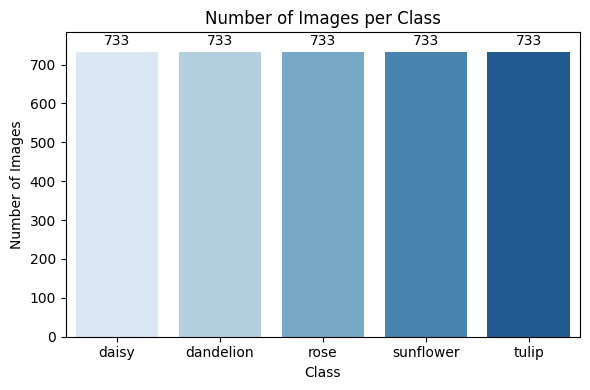

In [4]:
df['mean_pixel'] = df.drop(columns='label').mean(axis=1)
df['std_pixel'] = df.drop(columns='label').std(axis=1)

# Compute counts
counts = df['label'].value_counts().reindex(CLASSES)

# Create DataFrame for plotting
count_df = pd.DataFrame({'label': counts.index, 'count': counts.values})

plt.figure(figsize=(6,4))
sns.barplot(data=count_df, x='label', y='count', palette='Blues')
plt.title("Number of Images per Class")
plt.ylim(0, count_df['count'].max() + 50)

# Add actual values on top of bars
for i, row in count_df.iterrows():
    plt.text(i, row['count'] + 10, str(row['count']),
             ha='center', va='bottom', color='black', fontsize=10)

plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.tight_layout()
plt.show()

### Pixel Statistics by Class

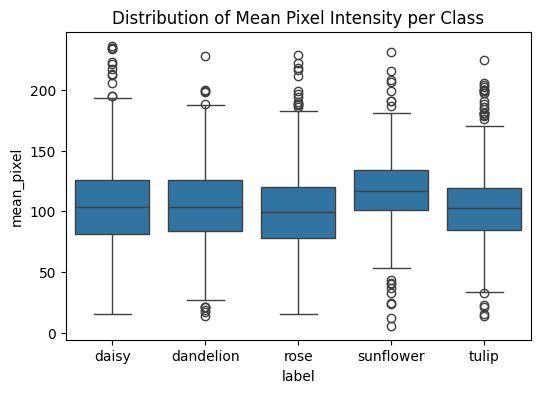

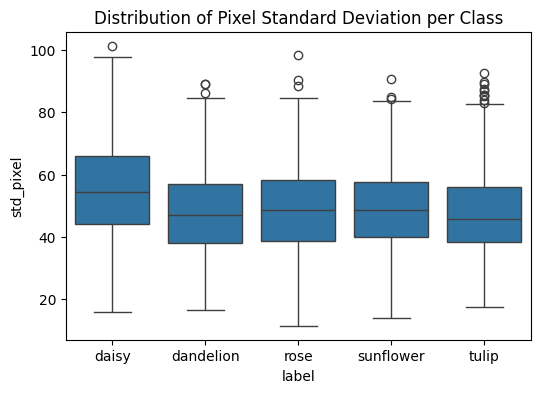

In [5]:
# Mean pixel intensity per class
plt.figure(figsize=(6,4))
sns.boxplot(x='label', y='mean_pixel', data=df)
plt.title("Distribution of Mean Pixel Intensity per Class")
plt.show()

# Std deviation of pixel intensity per class
plt.figure(figsize=(6,4))
sns.boxplot(x='label', y='std_pixel', data=df)
plt.title("Distribution of Pixel Standard Deviation per Class")
plt.show()

###  PCA Visualization
We'll visualize the first two principal components to see how well the classes are separable.

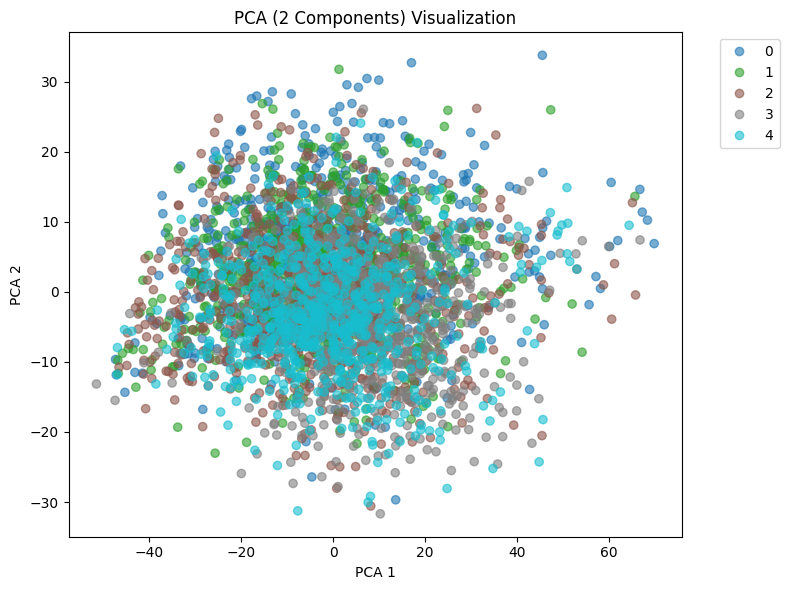

In [6]:
# Reduce to 2 PCA components for visualization
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X)

# Plot the 2D PCA projection
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='tab10', alpha=0.6)

# Automatically generate the legend handles and labels
handles, labels = scatter.legend_elements()
plt.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc='upper left')

# Add labels and title
plt.title("PCA (2 Components) Visualization")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.tight_layout()
plt.show()


##  Feature Engineering



In [7]:

# PCA: reduce to 150 components
pca = PCA(n_components=150)
X_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Polynomial features (degree 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_pca)
X_test_poly = poly.transform(X_test_pca)

# Feature Selection
selector = SelectKBest(score_func=mutual_info_classif, k=100)
X_selected = selector.fit_transform(X_poly, y_train)
X_test_selected = selector.transform(X_test_poly)


## Feature Insights and Contribution Analysis

 ### Mutual Information Scores

We analyze the top features selected by the `SelectKBest` method using mutual information scores.
This gives us insight into which features (original pixels, interactions, or engineered ones like mean/std)
were most informative for predicting the correct flower class.


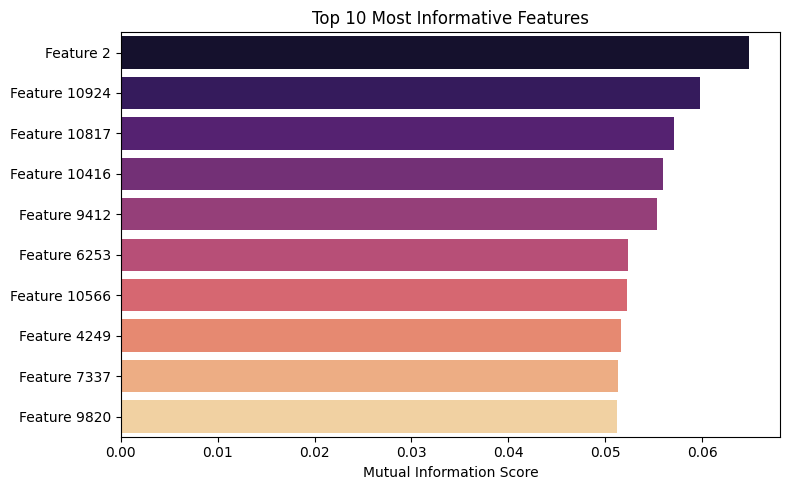

In [8]:
# Analyze feature importance based on mutual_info_classif scores
importances = selector.scores_

# Get the boolean mask of selected features
selected_mask = selector.get_support()
selected_indices = np.where(selected_mask)[0]

# Identify whether the selected feature is mean or std (they were appended at the end of the original image vector before PCA)
original_num_pixels = IMAGE_SIZE[0] * IMAGE_SIZE[1]  # 1024

feature_names = []
for idx in selected_indices:
    # Before PolynomialFeatures, we appended mean and std to the original image vector (at the end)
    if idx < len(importances):
        if idx == original_num_pixels:
            feature_names.append("Mean Pixel Intensity")
        elif idx == original_num_pixels + 1:
            feature_names.append("Pixel Intensity Std")
        else:
            feature_names.append(f"Feature {idx}")
    else:
        feature_names.append(f"Feature {idx}")

# Choose the 10 most important selected features
selected_importances = [(name, importances[i]) for name, i in zip(feature_names, selected_indices)]
top_features = sorted(selected_importances, key=lambda x: x[1], reverse=True)[:10]

# Plot
top_names = [name for name, _ in top_features]
top_scores = [score for _, score in top_features]
plt.figure(figsize=(8, 5))
sns.barplot(x=top_scores, y=top_names, palette="magma")
plt.xlabel("Mutual Information Score")
plt.title("Top 10 Most Informative Features")
plt.tight_layout()
plt.show()

### Top Features Boxplot Visualization


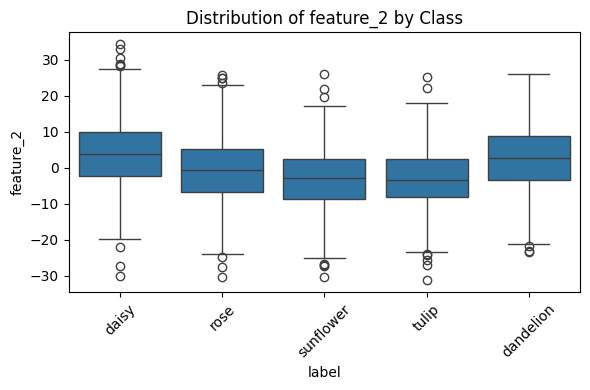

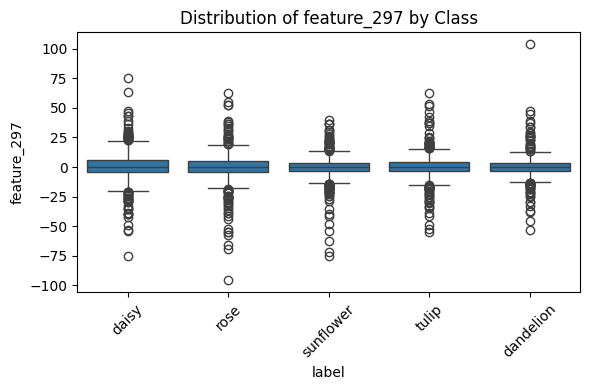

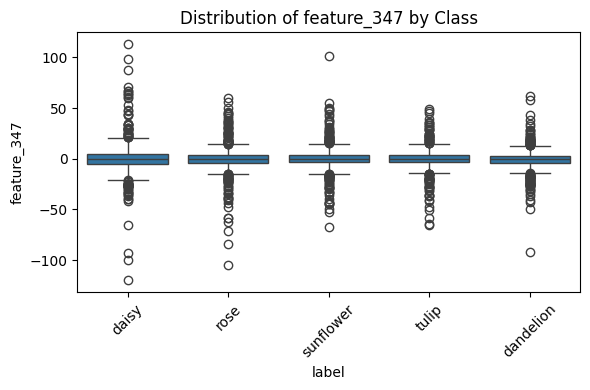

In [9]:
# Get top 3 selected feature indices
top_features_idx = selector.get_support(indices=True)[:3]

df_vis = pd.DataFrame(X_selected[:, :3], columns=[f'feature_{i}' for i in top_features_idx])
df_vis['label'] = le.inverse_transform(y_train)

for col in df_vis.columns[:-1]:  # Exclude the label column
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='label', y=col, data=df_vis)
    plt.title(f'Distribution of {col} by Class')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


##  Visualization Utilities

In [10]:

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = sk_confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_model_metrics(metrics_dict):
    labels = list(metrics_dict.keys())
    accuracy = [v['accuracy'] for v in metrics_dict.values()]
    precision = [v['precision'] for v in metrics_dict.values()]
    recall = [v['recall'] for v in metrics_dict.values()]
    x = np.arange(len(labels))
    width = 0.25
    plt.figure(figsize=(10, 6))
    plt.bar(x - width, accuracy, width, label='Accuracy')
    plt.bar(x, precision, width, label='Precision')
    plt.bar(x + width, recall, width, label='Recall')
    plt.xticks(x, labels, rotation=45)
    plt.ylabel("Score")
    plt.title("Comparison of Models")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Model Definitions & Training
> In the next part we will define upgraded versions of our four main models:
- KNN with custom distance
- Logistic Regression with regularization
- SVM with tuning
- Naive Bayes with selected features

Then we will compare all models and add an ensemble voting classifier.

### Define Models with Grid Search

In [11]:
# KNN with custom Manhattan distance and Grid Search for k
# We'll wrap KNeighborsClassifier with our custom distance via 'metric' param = 'manhattan'
knn_params = {'n_neighbors': [3,5,7,9],
              'weights': ['uniform','distance']}

knn_model = KNeighborsClassifier(metric='manhattan')
knn_grid = GridSearchCV(knn_model, knn_params, cv=3, n_jobs=-1)

# 2) Logistic Regression w/ L2 + Grid Search for C
log_params = {'C': [0.01, 0.1, 1, 10],
              'max_iter': [500, 1000]}

log_model = LogisticRegression(solver='lbfgs', penalty='l2')
log_grid = GridSearchCV(log_model, log_params, cv=3, n_jobs=-1)

# 3) SVM w/ RBF + Grid Search
svm_params = {'C': [0.01, 0.1, 1, 10],
              'gamma': ['scale','auto']}
svm_model = SVC(kernel='rbf', probability=True)
svm_grid = GridSearchCV(svm_model, svm_params, cv=3, n_jobs=-1)

# 4) Naive Bayes w/ PCA + selected features (already done in stage1, let's just wrap it)
# Actually we can do a simple GaussianNB but it's not typically set with many hyperparams
nb_model = GaussianNB()

# We'll keep it simple for NB (no grid search).


###  Train and Evaluate Models

In [12]:

# We'll use X_selected and X_test_selected from the advanced feature pipeline
X_tr = X_selected
X_te = X_test_selected

models_scores = {}

# KNN
start = time.time()
knn_grid.fit(X_tr, y_train)
end = time.time()
best_knn = knn_grid.best_estimator_
y_pred_knn = best_knn.predict(X_te)
knn_acc = np.mean(y_pred_knn == y_test)

knn_prec = precision_score(y_test, y_pred_knn, average='macro')
knn_rec = recall_score(y_test, y_pred_knn, average='macro')

models_scores['KNN'] = {
    'accuracy': knn_acc,
    'precision': knn_prec,
    'recall': knn_rec,
    'train_time': end - start,
    'best_params': knn_grid.best_params_
}

print(f"=== KNN ===\nBest Params: {knn_grid.best_params_}\nAccuracy: {knn_acc:.3f}, Precision: {knn_prec:.3f}, Recall: {knn_rec:.3f}, Train Time: {end - start:.2f}s")


# Logistic Regression
start = time.time()
log_grid.fit(X_tr, y_train)
end = time.time()
best_log = log_grid.best_estimator_
y_pred_log = best_log.predict(X_te)
log_acc = np.mean(y_pred_log == y_test)
log_prec = precision_score(y_test, y_pred_log, average='macro')
log_rec = recall_score(y_test, y_pred_log, average='macro')

models_scores['Logistic'] = {
    'accuracy': log_acc,
    'precision': log_prec,
    'recall': log_rec,
    'train_time': end - start,
    'best_params': log_grid.best_params_
}

print(f"\n=== Logistic Regression ===\nBest Params: {log_grid.best_params_}\nAccuracy: {log_acc:.3f}, Precision: {log_prec:.3f}, Recall: {log_rec:.3f}, Train Time: {end - start:.2f}s")


# SVM
start = time.time()
svm_grid.fit(X_tr, y_train)
end = time.time()
best_svm = svm_grid.best_estimator_
y_pred_svm = best_svm.predict(X_te)
svm_acc = np.mean(y_pred_svm == y_test)
svm_prec = precision_score(y_test, y_pred_svm, average='macro')
svm_rec = recall_score(y_test, y_pred_svm, average='macro')

models_scores['SVM'] = {
    'accuracy': svm_acc,
    'precision': svm_prec,
    'recall': svm_rec,
    'train_time': end - start,
    'best_params': svm_grid.best_params_
}

print(f"\n=== SVM ===\nBest Params: {svm_grid.best_params_}\nAccuracy: {svm_acc:.3f}, Precision: {svm_prec:.3f}, Recall: {svm_rec:.3f}, Train Time: {end - start:.2f}s")


# Naive Bayes
# We assume no grid search for NB
start = time.time()
nb_model.fit(X_tr, y_train)
end = time.time()
y_pred_nb = nb_model.predict(X_te)
nb_acc = np.mean(y_pred_nb == y_test)
nb_prec = precision_score(y_test, y_pred_nb, average='macro')
nb_rec = recall_score(y_test, y_pred_nb, average='macro')

models_scores['Naive Bayes'] = {
    'accuracy': nb_acc,
    'precision': nb_prec,
    'recall': nb_rec,
    'train_time': end - start,
    'best_params': None
}

print(f"\n=== Naive Bayes ===\nAccuracy: {nb_acc:.3f}, Precision: {nb_prec:.3f}, Recall: {nb_rec:.3f}, Train Time: {end - start:.2f}s")



=== KNN ===
Best Params: {'n_neighbors': 7, 'weights': 'distance'}
Accuracy: 0.271, Precision: 0.300, Recall: 0.275, Train Time: 4.61s

=== Logistic Regression ===
Best Params: {'C': 0.1, 'max_iter': 500}
Accuracy: 0.293, Precision: 0.288, Recall: 0.289, Train Time: 0.81s

=== SVM ===
Best Params: {'C': 1, 'gamma': 'scale'}
Accuracy: 0.338, Precision: 0.337, Recall: 0.337, Train Time: 23.22s

=== Naive Bayes ===
Accuracy: 0.306, Precision: 0.281, Recall: 0.302, Train Time: 0.01s


##  Evaluation and Visualization

### Confusion Matrices

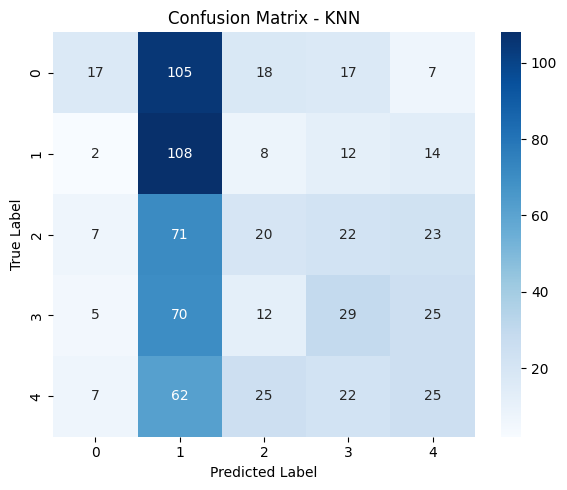

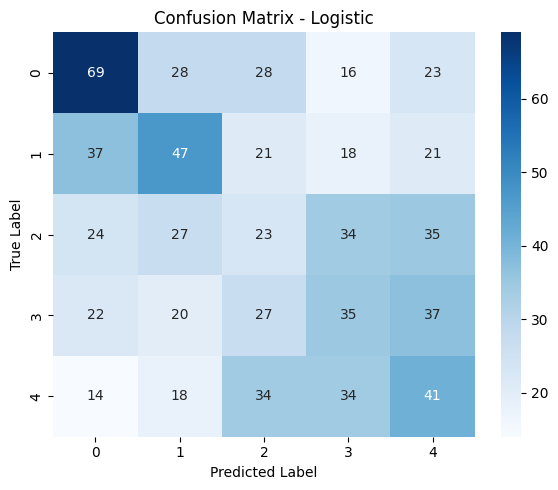

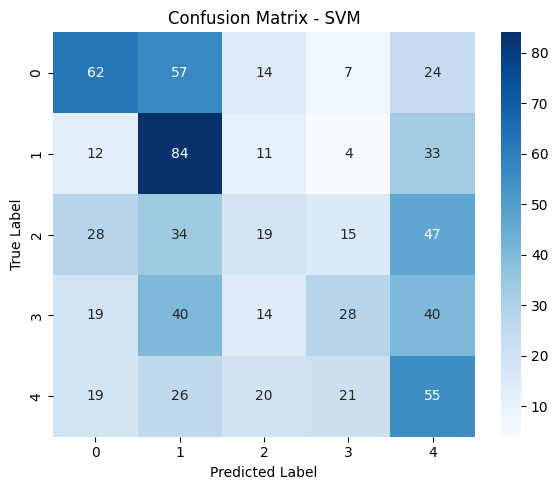

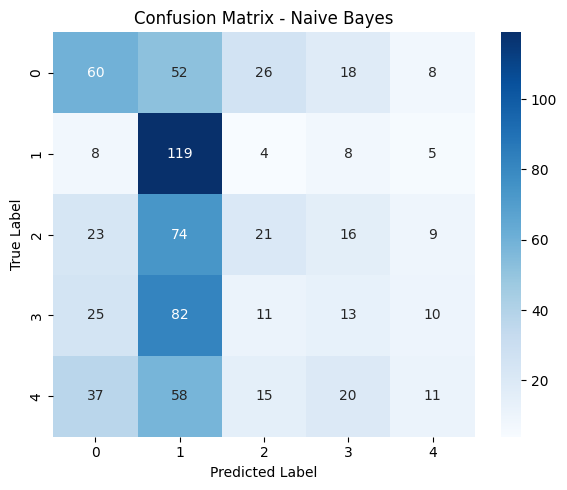

In [13]:
for model_name, score_info in models_scores.items():
    if model_name == 'KNN':
        y_pred = y_pred_knn
    elif model_name == 'Logistic':
        y_pred = y_pred_log
    elif model_name == 'SVM':
        y_pred = y_pred_svm
    else:
        y_pred = y_pred_nb

    plot_confusion_matrix(y_test, y_pred, title=f"Confusion Matrix - {model_name}")


###  Weighted Voting Ensemble

Instead of majority voting, we assign weights based on model accuracies


=== Weighted Voting Ensemble ===
🔢 Raw Accuracy Scores (before normalization):
KNN: 0.2715
Logistic: 0.2933
SVM: 0.3383
NaiveBayes: 0.3056

⚖️ Normalized Weights (used in ensemble):
KNN: 0.2246
Logistic: 0.2427
SVM: 0.2799
NaiveBayes: 0.2528


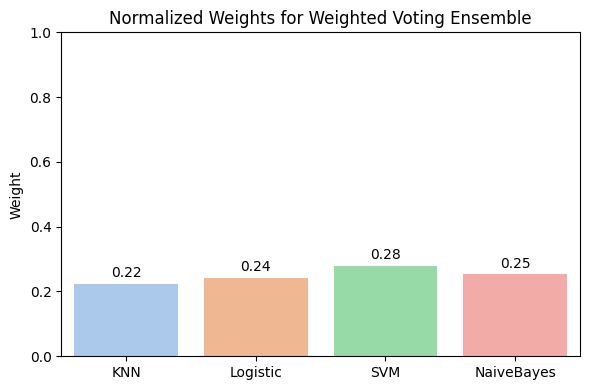

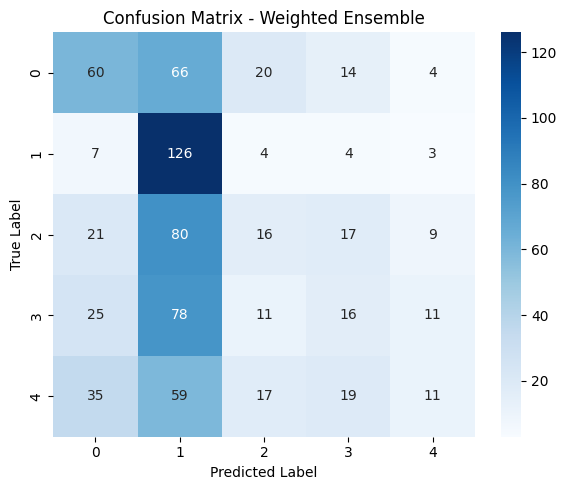


📊 Accuracy: 0.312, Precision: 0.293, Recall: 0.309


In [14]:
# Extract accuracy scores from previous models
raw_weights = {
    'KNN': models_scores['KNN']['accuracy'],
    'Logistic': models_scores['Logistic']['accuracy'],
    'SVM': models_scores['SVM']['accuracy'],
    'NaiveBayes': models_scores['Naive Bayes']['accuracy']
}

# Normalize weights so they sum to 1
total = sum(raw_weights.values())
normalized_weights = {k: v / total for k, v in raw_weights.items()}

# Create Weighted Ensemble (soft voting)
weighted_ensemble = VotingClassifier(
    estimators=[
        ('knn', best_knn),
        ('logistic', best_log),
        ('svm', best_svm),
        ('nb', nb_model)
    ],
    voting='soft',
    weights=[normalized_weights['KNN'], normalized_weights['Logistic'],
             normalized_weights['SVM'], normalized_weights['NaiveBayes']]
)

# Fit and Predict
start = time.time()
weighted_ensemble.fit(X_tr, y_train)
y_pred_ens = weighted_ensemble.predict(X_te)
end = time.time()
ensemble_time = end - start

# Evaluate Performance
ens_acc = np.mean(y_pred_ens == y_test)
ens_prec = precision_score(y_test, y_pred_ens, average='macro')
ens_rec = recall_score(y_test, y_pred_ens, average='macro')

# Save Results
models_scores['Ensemble_Weighted']= {
    'accuracy': ens_acc,
    'precision': ens_prec,
    'recall': ens_rec,
    'train_time': ensemble_time,
    'best_params': normalized_weights
}

# Print Results and Weights
print("\n=== Weighted Voting Ensemble ===")
print("🔢 Raw Accuracy Scores (before normalization):")
for model, score in raw_weights.items():
    print(f"{model}: {score:.4f}")

print("\n⚖️ Normalized Weights (used in ensemble):")
for model, weight in normalized_weights.items():
    print(f"{model}: {weight:.4f}")

# Bar Chart of Normalized Weights
plt.figure(figsize=(6, 4))
sns.barplot(x=list(normalized_weights.keys()), y=list(normalized_weights.values()), palette="pastel")
plt.title("Normalized Weights for Weighted Voting Ensemble")
plt.ylabel("Weight")
plt.ylim(0, 1)
for i, val in enumerate(normalized_weights.values()):
    plt.text(i, val + 0.02, f"{val:.2f}", ha='center', fontsize=10)
plt.tight_layout()
plt.show()

# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred_ens, title="Confusion Matrix - Weighted Ensemble")

print(f"\n📊 Accuracy: {ens_acc:.3f}, Precision: {ens_prec:.3f}, Recall: {ens_rec:.3f}")


###  Model Comparison

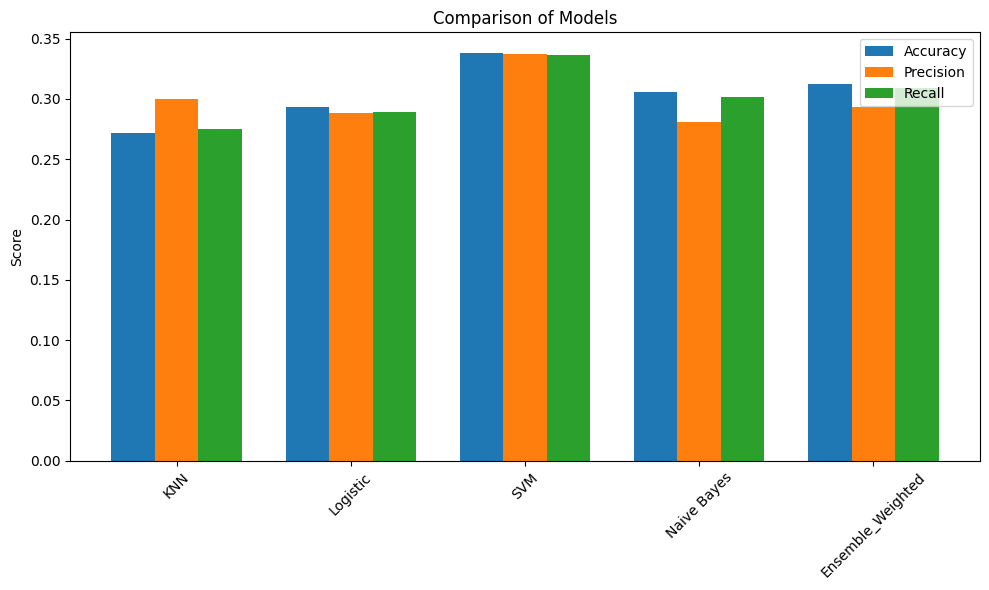

In [15]:

# Convert to dict suitable for plot_model_metrics
plot_dict = {}
for model_name, info in models_scores.items():
    plot_dict[model_name] = {
        'accuracy': info['accuracy'],
        'precision': info['precision'],
        'recall': info['recall']
    }

plot_model_metrics(plot_dict)


##  Training Time Comparison

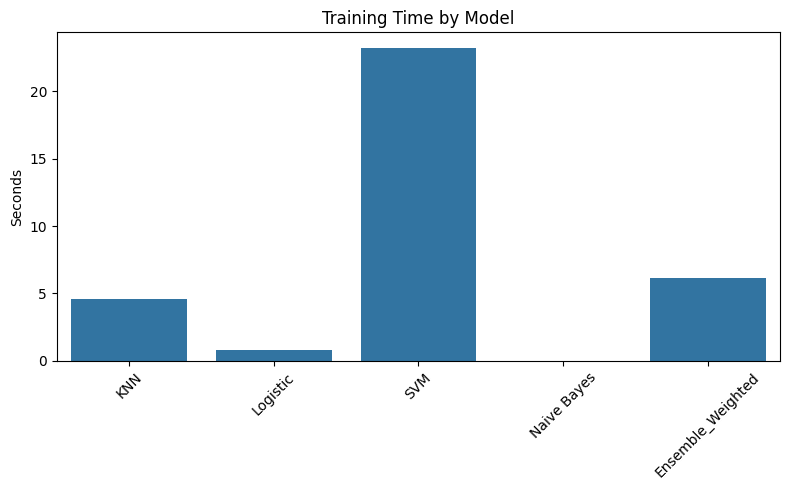

In [16]:

train_times = {k: v['train_time'] for k, v in models_scores.items() if v['train_time'] is not None}

plt.figure(figsize=(8,5))
sns.barplot(x=list(train_times.keys()), y=list(train_times.values()))
plt.title("Training Time by Model")
plt.ylabel("Seconds")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##  Model Performance Summary Table

In [17]:
# Convert models_scores to DataFrame
summary_df = pd.DataFrame(models_scores).T[['accuracy', 'precision', 'recall', 'train_time']]

# Convert None to np.nan to avoid formatting issues
summary_df = summary_df.replace({None: np.nan})

# Sort by accuracy
summary_df = summary_df.sort_values(by='accuracy', ascending=False)

# Display styled table
summary_df.style.background_gradient(cmap='Greens').format("{:.3f}")


,accuracy,precision,recall,train_time
SVM,0.338,0.337,0.337,23.217
Ensemble_Weighted,0.312,0.293,0.309,6.177
Naive Bayes,0.306,0.281,0.302,0.006
Logistic,0.293,0.288,0.289,0.806
KNN,0.271,0.300,0.275,4.606


## Error Analysis and Model Diagnostics

### Most Frequently Confused Classes

In [18]:
# Compute confusion matrix for the ensemble model
cm = confusion_matrix(y_test, y_pred_ens)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

# Create temporary confusion matrix with diagonal zeroed (only for identifying confusion)
cm_temp = cm_df.copy()
np.fill_diagonal(cm_temp.values, 0)

# Find the most confused class pair
most_confused_pair = cm_temp.stack().idxmax()
most_confused_count = cm_temp.stack().max()

print(f"🔄 Most confused pair: {most_confused_pair[0]} → {most_confused_pair[1]} ({most_confused_count} mistakes)")


🔄 Most confused pair: rose → dandelion (80 mistakes)


### Visual Analysis of Confused Classes


Most confused pair: rose vs dandelion


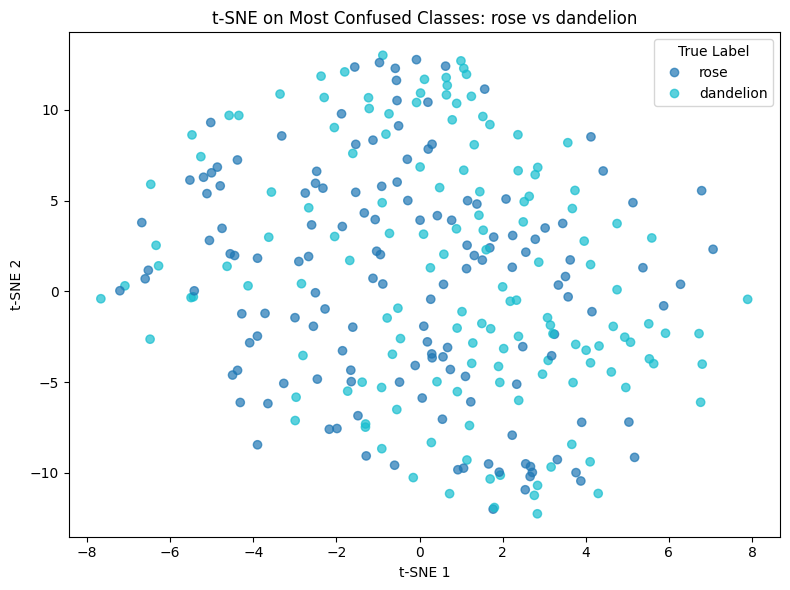

In [19]:
# Use the already computed most_confused_pair (label names)
label1, label2 = most_confused_pair
print(f"Most confused pair: {label1} vs {label2}")

# Get their encoded numeric values
label1_encoded = le.transform([label1])[0]
label2_encoded = le.transform([label2])[0]

# Filter test set to only include these two classes
mask = (y_test == label1_encoded) | (y_test == label2_encoded)
X_filtered = X_test[mask]
y_filtered = y_test[mask]

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_filtered)

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_filtered, cmap='tab10', alpha=0.7)
plt.title(f"t-SNE on Most Confused Classes: {label1} vs {label2}")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

# Add legend with actual label names
handles, labels = scatter.legend_elements()
plt.legend(handles, [label1, label2], title="True Label")

plt.tight_layout()
plt.show()


###  Class-wise Error Counts

In [20]:
# Create cm_errors matrix (diagonal set to zero)
cm_errors = cm_df.copy()
np.fill_diagonal(cm_errors.values, 0)

# Compute total number of errors per actual class
errors_per_class = cm_errors.sum(axis=1).sort_values(ascending=False)

print("📉 Errors per class (most errors on top):")
display(errors_per_class)


📉 Errors per class (most errors on top):


tulip        130
rose         127
sunflower    125
daisy        104
dandelion     18
dtype: int64

### Hardest Test Samples 


In [21]:
# Collect predictions from all models into a dictionary
model_preds = {
    "KNN": y_pred_knn,
    "Logistic": y_pred_log,
    "SVM": y_pred_svm,
    "NaiveBayes": y_pred_nb
}

# Convert to NumPy array for easier processing — shape: (4 models, num_samples)
model_preds_arr = np.array(list(model_preds.values()))

# Count how many models misclassified each test sample
errors_per_sample = [
    sum(model_preds_arr[:, i] != y_test[i]) 
    for i in range(len(y_test))
]
errors_series = pd.Series(errors_per_sample)

# Select test samples where at least 3 models failed
hardest_idxs = errors_series[errors_series >= 3].index

# Get the actual class names of the hardest samples
hardest_labels = le.inverse_transform(y_test[hardest_idxs])

# Count how many of the hardest samples belong to each class
hardest_class_distribution = pd.Series(hardest_labels).value_counts()

print("Distribution of hardest examples (where 3+ models failed):")
display(hardest_class_distribution)


Distribution of hardest examples (where 3+ models failed):


rose         123
sunflower    112
daisy         99
tulip         98
dandelion     36
Name: count, dtype: int64

### Visual Analysis of Hardest Samples


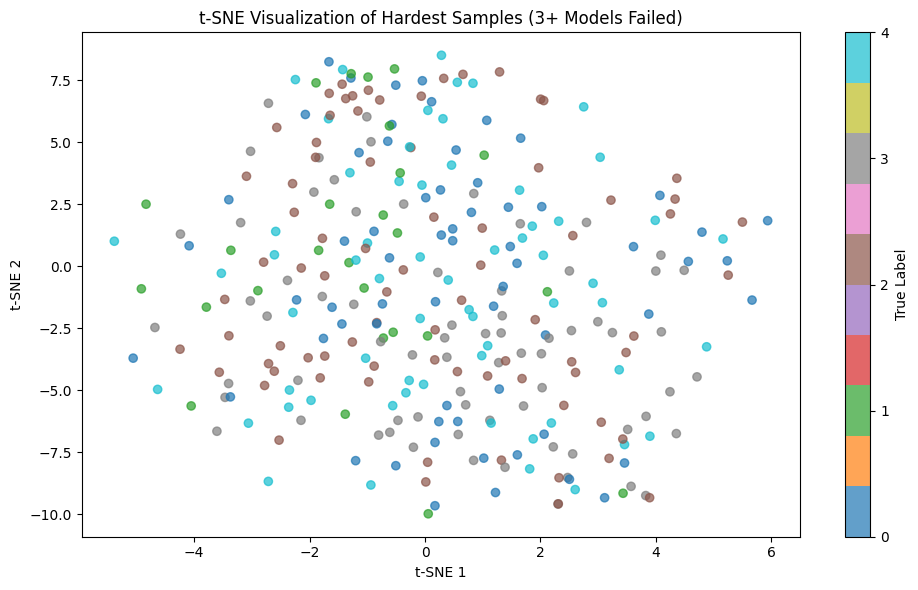

In [22]:
# Select hardest examples (where at least 3 models failed)
hardest_idxs = errors_series[errors_series >= 3].index
X_hardest = X_test[hardest_idxs]
y_hardest = y_test[hardest_idxs]

# Optional: Limit to subset for speed (t-SNE is slow on large sets)
max_samples = 300
if len(hardest_idxs) > max_samples:
    subset = np.random.choice(hardest_idxs, size=max_samples, replace=False)
    X_hardest = X_test[subset]
    y_hardest = y_test[subset]

# Run t-SNE to reduce features to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne_2d = tsne.fit_transform(X_hardest)

# Plot the result
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1], c=y_hardest, cmap='tab10', alpha=0.7)

plt.title("t-SNE Visualization of Hardest Samples (3+ Models Failed)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(scatter, ticks=np.unique(y_hardest), label="True Label")
plt.tight_layout()
plt.show()
